# Zaawansowane Metody Inteligencji Obliczeniowej
## Lab 8: Q-Learning z aproksymacją
### Prowadzący: Michał Kempka, Marek Wydmuch

## Wprowadzenie

Celem tego ćwiczenia jest implementacja algorytmu Q-Learning z aproksymacją dla środowiska `CartPole` ze znanej Wam już bibliteki OpenAI Gym (https://gym.openai.com).


Zapoznaj się z opisem środowiska (https://gym.openai.com/envs/CartPole-v1) następnie zapoznaj się z kodem poniżej. Pokazuje on przykład użycia omawianego środowiska.

In [1]:
# Zainstaluj bibliotekę OpenAI Gym i PyTorch
!pip install gym torch matplotlib numpy
# W wypadku problemów z działąniem na macOS Big Sur uruchom również poniższą linię
#!pip install pyglet==1.5.15

  Using cached gym-0.26.2-py3-none-any.whl
  Using cached torch-2.0.0-cp38-cp38-win_amd64.whl (172.3 MB)
  Using cached matplotlib-3.7.1-cp38-cp38-win_amd64.whl (7.6 MB)
  Using cached gym_notices-0.0.8-py3-none-any.whl (3.0 kB)
  Using cached cloudpickle-2.2.1-py3-none-any.whl (25 kB)
  Using cached filelock-3.11.0-py3-none-any.whl (10.0 kB)
  Using cached Jinja2-3.1.2-py3-none-any.whl (133 kB)
  Using cached networkx-3.1-py3-none-any.whl (2.1 MB)
  Using cached contourpy-1.0.7-cp38-cp38-win_amd64.whl (162 kB)
  Using cached fonttools-4.39.3-py3-none-any.whl (1.0 MB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached importlib_resources-5.12.0-py3-none-any.whl (36 kB)
  Using cached pyparsing-3.0.9-py3-none-any.whl (98 kB)
  Using cached Pillow-9.5.0-cp38-cp38-win_amd64.whl (2.5 MB)
  Using cached kiwisolver-1.4.4-cp38-cp38-win_amd64.whl (55 kB)


You should consider upgrading via the 'c:\users\dell latitude\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


### Środowisko `CartPole`

Poniższy kod demonstruje działanie środowiska `CartPole`

In [12]:
# Zobacz jak działa środowisko na przykładzie 1000 kroków
import gym

env = gym.make("CartPole-v1")
observation = env.reset()
for _ in range(1000):
    env.render()
    action = env.action_space.sample()
    observation, reward, done, info, _ = env.step(action)

    if done:
        observation = env.reset()
env.close()

In [13]:
# Zobacz jakim typem są obserwacje (reprezentacja stanu) oraz jaka jest przestrzeń akcji:
print("Przestrzeń stanów:", env.observation_space)
print("Ostatnia obserwacja:", observation)
print("Przestrzeń akcji:", env.action_space)

Przestrzeń stanów: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Ostatnia obserwacja: [ 0.05065029  0.18679495 -0.16937424 -0.6291693 ]
Przestrzeń akcji: Discrete(2)


### Regresja w PyTorch

Poniższy kod demosntruje jak stworzyć prosty model za pomocą bilibteki PyTorch dla problemu regresji.

In [14]:
import torch
import torch.nn.functional as F

class MyModel(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(MyModel, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)  # Warstwa wejściowa
        self.predict = torch.nn.Linear(n_hidden, n_output)  # Warstwa wyjściowa

    # W momencie wykonania tych operacji zostanie stworzony graf obliczeniowy, który zostanie wykorzystany do propagacji wstecznej
    def forward(self, x):
        x = F.relu(self.hidden(x))  # Wejście + funkcja aktywacji
        x = self.predict(x)         # Liniowe wyjście
        return x

h = MyModel(n_feature=1, n_hidden=50, n_output=1)

# Poza samym modelem, w celu jego uczenia potrzebujemy optymalizatora (w tym wypadku algorytmu SGD)
optimizer = torch.optim.SGD(h.parameters(), lr=0.2)

# Oraz naszej funkcji straty, w tym wypadku błędu kwadratowego
loss_func = torch.nn.MSELoss()

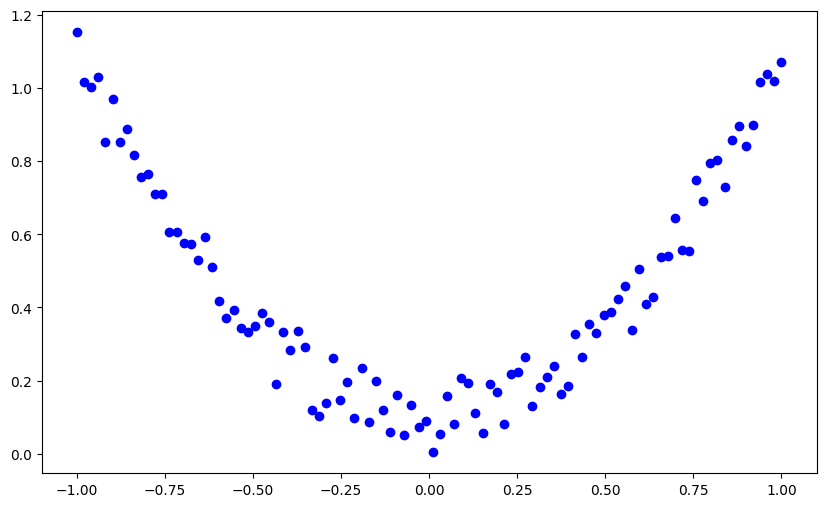

In [15]:
# Stwórzmy przykładowe, jednowmiarowe dane i wyświetlmy je
import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(1)
x = torch.unsqueeze(torch.linspace(-1, 1, 100), dim=1)
y = x.pow(2) + 0.2 * torch.rand(x.size())

plt.figure(figsize=(10,6))
plt.scatter(x.data.numpy(), y.data.numpy(), color="blue")
plt.show()

In [16]:
# Wytrenujmy nasz model wykonując 1000 iteracji po całym zbiorze danych
for t in range(1000):
    # Dokonaj predykcji na podstawie x
    prediction = h(x) 
    
    # Wyliczmy błąd
    loss = loss_func(prediction, y)
    
    # Wyzerujmy gradienty
    optimizer.zero_grad()
    
    # Wylicz gradienty dla każdej operacji z użyciem propagacji wstecznej
    loss.backward()

    # Zaktualizuj wagi
    optimizer.step()

In [17]:
# Wykonajmy ostateczną predykcję, nie potrzebujemy już gradientów ani grafu obliczeniowego
with torch.no_grad():
    prediction = h(x)

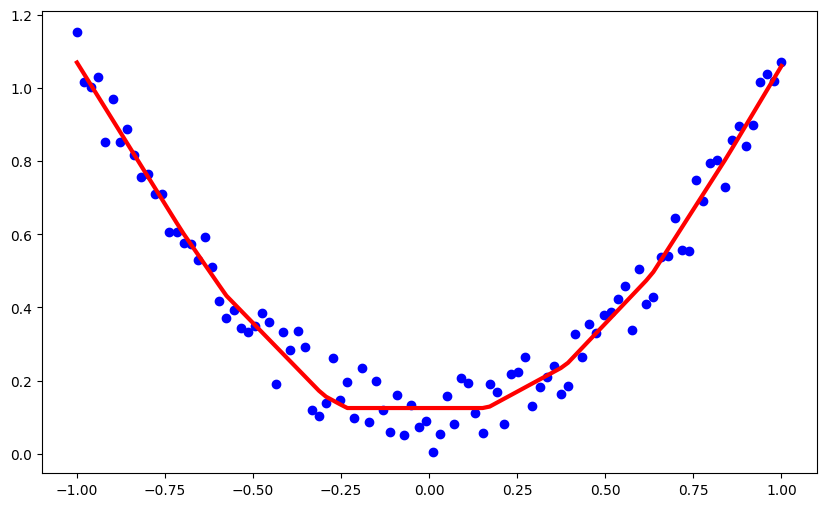

In [18]:
# Wyświetlmy wyniki
plt.figure(figsize=(10,6))
plt.scatter(x.data.numpy(), y.data.numpy(), color="blue")
plt.plot(x.data.numpy(), prediction.data.numpy(), color="red", lw=3)
plt.show()

## Ćwiczenie: zaimplementuj algorytm Q-Learning z aproksymacją dla środowiska `CartPole`

In [19]:
class QModel(torch.nn.Module):
    def __init__(self, n_feature, n1_hidden, n2_hidden, n_output):
        super(QModel, self).__init__()
        self.hidden1 = torch.nn.Linear(n_feature, n1_hidden)  # Warstwa wejściowa
        self.hidden2 = torch.nn.Linear(n1_hidden, n2_hidden) 
        self.predict = torch.nn.Linear(n2_hidden, n_output)  # Warstwa wyjściowa

    # W momencie wykonania tych operacji zostanie stworzony graf obliczeniowy, który zostanie wykorzystany do propagacji wstecznej
    def forward(self, x):
        x = F.relu(self.hidden1(x))  # Wejście + funkcja aktywacji
        x = F.relu(self.hidden2(x))
        x = self.predict(x)         # Liniowe wyjście
        return x



In [20]:
!pip install tqdm

You should consider upgrading via the 'c:\users\dell latitude\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [21]:
from tqdm import trange
from random import random

def predict(h, S):
    with torch.no_grad():
        return h(torch.Tensor(S))

def qlearning(env, h, episodes, optim, gamma=0.9, epsilon=0.1, eps_decay=0.99):
    loss_func = torch.nn.MSELoss()# Poza samym modelem, w celu jego uczenia potrzebujemy optymalizatora (w tym wypadku algorytmu SGD)
    rewards = []
    for episode in trange(episodes):
        S = env.reset()
        done = False
        total_R = 0

        while not done:
            Q = predict(h, S)
            if random() < epsilon:
                A = env.action_space().sample()
            else:
                A = torch.argmax(Q).item()
            total_R += R

            if done:
                target = R
            else:
                next_S, R, done, _, _ = env.step(A) 
                next_Q = predict(h, next_S)
                max_next_Q = torch.max(next_Q).item()

                target = R + gamma * max_next_Q

            pred = Q[A] 
            loss = loss_func(pred, torch.Tensor([target]))
            optim.zero_grad()
            loss.backward()
            optim.step()

            S = next_S
        
        epsilon = max(epsilon * eps_decay, 0.01)
        reward.append(total_R)
    
    return rewards


In [24]:
env = gym.make("CartPole-v1")
h - MyModel(4, 2, 1)

optim = torch.optim.SGD(h.parameters(), lr=0.001)

rewards = []


TypeError: unsupported operand type(s) for -: 'MyModel' and 'MyModel'

In [ ]:
rewards.extend(qlearning(env, h, 1000, optim))
plt.figure(figsize=(10, 4))
plt.plot(rewards)
plt.show()

